In [1]:
import os
import pickle
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D

Загружаем данные

In [2]:
os.chdir('..')

In [3]:
names = ['arab', 'juncea', 'nigra', 'rapa']

In [4]:
small_components_all = {}
small_components_families_all = {}
largest_component_all = {}
largest_component_families_all = {}

G_small_all = {}
G_largest_all = {}

node_family_dict_all = {}
node_freq_dict_all = {}

node2name_dict_all = {}
name2seq_all = {}

In [5]:
# Функция для загрузки данных из файла
def load_data_from_file(filename):
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None

# Процесс получения маленьких компонент
def process_components(name):
    small_components_filename = os.path.join('data', f'data_{name}.pkl')
    if os.path.exists(small_components_filename):
        data = load_data_from_file(small_components_filename)
        if data:
            G_small_components = data['small_components']
            G_largest_component = data['largest_component']
            node_family_dict = data['node_family_dict']
            node_freq_dict = data['node_freq_dict']

            
            node_family_dict_all[name] = node_family_dict
            node_freq_dict_all[name] = node_freq_dict
            G_small_all[name] = G_small_components
            G_largest_all[name] = G_largest_component
            
        return True
    return False

# Процесс получения меток для маленьких компонент
def process_small_components(name):
    small_components_families_filename = os.path.join('data', f'small_components_families_{name}.pkl')
    if os.path.exists(small_components_families_filename):
        data = load_data_from_file(small_components_families_filename)
        if data:
            small_components_families_all[name] = data['families']
            small_components_all[name] = data['components']
        return True
    return False

# Процесс получения кластеров и меток для большой компоненты
def process_largest_component(name):
    largest_component_filename = os.path.join('data', f'largest_component_clusters_{name}.pkl')
    if os.path.exists(largest_component_filename):
        data = load_data_from_file(largest_component_filename)
        if data:
            largest_component = data['clusters']
            largest_component_families = data['families']
            
            largest_component_all[name] = largest_component
            largest_component_families_all[name] = largest_component_families
        return True
    return False


def process_dicts(name):
    dicts_filename = os.path.join('data', f'dicts_{name}.pkl')
    if os.path.exists(dicts_filename):
        data = load_data_from_file(dicts_filename)
        print(data)
        if data:
            
            node2name_dict = data['node2name_dict']
            name2seq = data['name2seq']
            
            node2name_dict_all[name] = node2name_dict
            name2seq_all[name] = name2seq
            
        return True
    return False
    

In [ ]:
for name in names:
    if not process_components(name):
        print(f"File for {name} (small components) not found.")
    
    if not process_small_components(name):
        print(f"File for {name} (small components families) not found.")
    
    if not process_largest_component(name):
        print(f"File for {name} (largest component) not found.")
    
    if not process_dicts(name):
        print(f"File for {name} (dicts) not found.")

# Эмбеддинги

In [ ]:
from funcs.embeddings import laplacian_eigenmaps_graph, arope_graph_embedding, node2vec_graph_embedding, characteristics

## Laplacian Eigenmaps

In [8]:
small_components_train = small_components_all['arab']
largest_component_train = largest_component_all['arab']

small_components_families_train = small_components_families_all['arab']
largest_component_families_train = largest_component_families_all['arab']

G_small = G_small_all['arab']
G_largest = G_largest_all['arab']

In [9]:
embeddings_laplacian_eigenmaps = []

for component_nodes in small_components_train:
    G_sub = G_small.subgraph(component_nodes)
    embedding_laplacian_eigenmaps = laplacian_eigenmaps_graph(G_sub, dim=5)
    embeddings_laplacian_eigenmaps.append(embedding_laplacian_eigenmaps)
    
for component_nodes in largest_component_train:
    G_sub = G_largest.subgraph(component_nodes)
    embedding_laplacian_eigenmaps = laplacian_eigenmaps_graph(G_sub, dim=5)
    embeddings_laplacian_eigenmaps.append(embedding_laplacian_eigenmaps)

embeddings_laplacian_eigenmaps[:5]

[array([4.85196341e-17, 4.22649731e-01, 1.00000000e+00, 1.57735027e+00,
        0.00000000e+00]),
 array([-9.8825843e-17,  1.0000000e+00,  1.0000000e+00,  1.0000000e+00,
         1.0000000e+00]),
 array([1.75107103e-16, 6.79579364e-02, 2.92893219e-01, 5.00000000e-01,
        7.80992561e-01]),
 array([3.64719387e-16, 3.64897268e-01, 7.37575264e-01, 1.00000000e+00,
        1.26242474e+00]),
 array([-1.99490839e-16,  1.37916932e-01,  3.63634987e-01,  4.22649731e-01,
         4.82238535e-01])]

Посмотрим, есть ли какая-то корреляция с метками

In [10]:
def pca_vizualization(X, y):
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', s=15)
    plt.colorbar(scatter, label='Class Labels')
    plt.title("PCA Visualization of Digits Dataset")
    unique_classes = np.unique(y_encoded)
    class_colors = scatter.cmap(scatter.norm(unique_classes))
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'Class {cls}', 
               markerfacecolor=class_colors[i], markersize=10)
        for i, cls in enumerate(unique_classes)
    ]
    plt.legend(handles=legend_elements, title="Classes", loc="best", fontsize="small")
    
    plt.show()


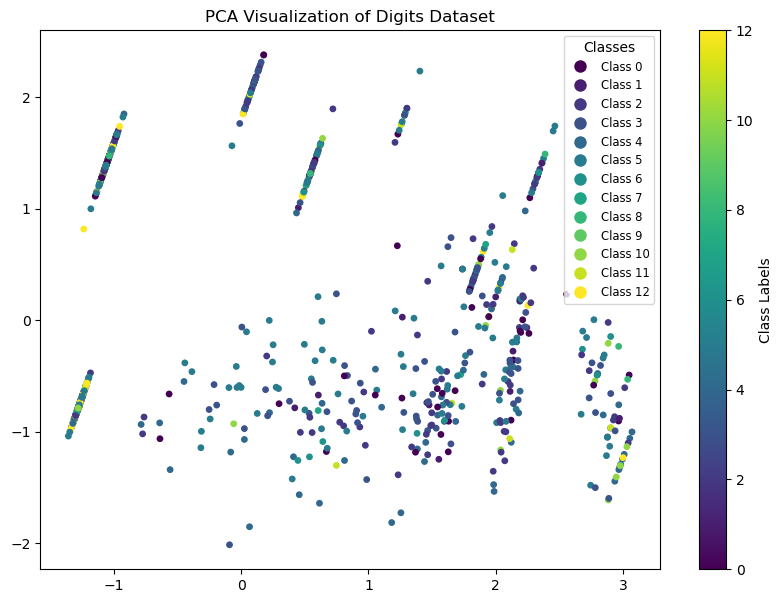

In [11]:
pca_vizualization(embeddings_laplacian_eigenmaps, small_components_families_train + largest_component_families_train)

## AROPE

In [12]:
embeddings_arope = []

for component_nodes in small_components_train:
    G_sub = G_small.subgraph(component_nodes)
    embedding_arope = arope_graph_embedding(G_sub, dim=10)
    embeddings_arope.append(embedding_arope)
    
for component_nodes in largest_component_train:
    G_sub = G_largest.subgraph(component_nodes)
    embedding_arope = arope_graph_embedding(G_sub, dim = 10)
    embeddings_arope.append(embedding_arope)

embeddings_arope[:5]

[array([0.76536686, 0.76536686, 1.84775907, 1.84775907, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([1.08607161e-96, 1.04387311e-79, 1.48955734e-63, 3.14125194e-47,
        1.48139921e-33, 4.70637699e-17, 5.73729377e-16, 3.00000000e+00,
        3.00000000e+00, 0.00000000e+00]),
 array([0.33673484, 0.72878254, 0.72878254, 1.18967895, 1.18967895,
        1.70696564, 1.70696564, 2.00659362, 2.00659362, 0.        ]),
 array([0.55910682, 0.55910682, 1.25234695, 1.25234695, 2.47366665,
        2.47366665, 0.        , 0.        , 0.        , 0.        ]),
 array([0.91353316, 0.91353316, 1.        , 1.        , 1.39211339,
        1.39211339, 2.73760671, 2.73760671, 5.89346986, 5.89346986])]

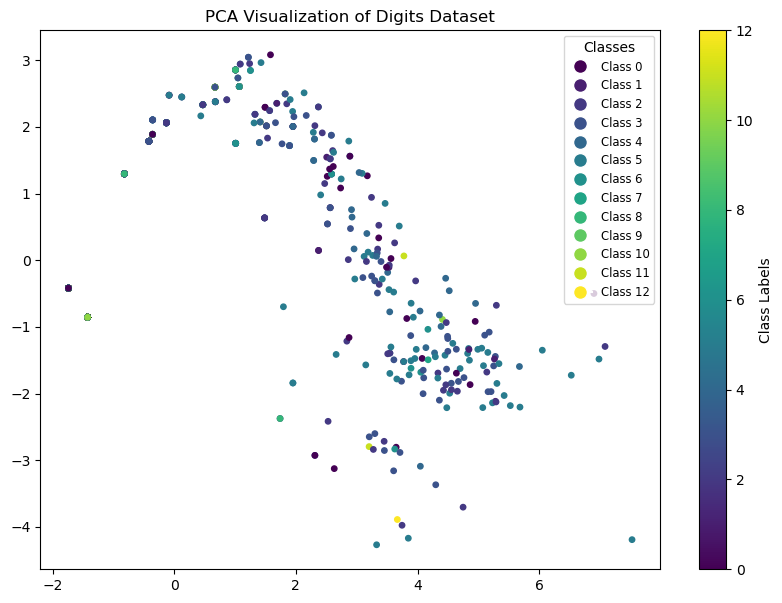

In [13]:
pca_vizualization(embeddings_arope, small_components_families_train + largest_component_families_train)

## Node2Vec

In [ ]:
import logging

logging.basicConfig(level=logging.CRITICAL)

embeddings_node2vec = []

for component_nodes in small_components_train:
    G_sub = G_small.subgraph(component_nodes)
    embedding_node2vec = node2vec_graph_embedding(G_sub, dim=10)
    embeddings_node2vec.append(embedding_node2vec)

for component_nodes in largest_component_train:
    G_sub = G_largest.subgraph(component_nodes)
    embedding_node2vec = node2vec_graph_embedding(G_sub, dim=10)
    embeddings_node2vec.append(embedding_node2vec)

In [15]:
embeddings_node2vec[:5]

[array([ 0.14914994,  0.07835631,  0.08360863,  0.28382626, -0.27605003,
        -0.28387916,  0.21693428,  0.34946966, -0.42757154, -0.38656026],
       dtype=float32),
 array([ 0.17775092,  0.43577138,  0.13874008, -0.13489538, -0.05062566,
        -0.14754818,  0.41800466,  0.22185722, -0.45299616, -0.36821967],
       dtype=float32),
 array([ 0.23247953,  0.38487637, -0.14710118,  0.01793053, -0.08046292,
        -0.14879517,  0.24592061,  0.34357923, -0.43161488, -0.29931197],
       dtype=float32),
 array([-0.3971579 ,  0.26510587, -0.18213288,  0.00913688,  0.02336455,
        -0.36539212,  0.31617644,  0.12205581, -0.43812698,  0.07998471],
       dtype=float32),
 array([-0.1383492 , -0.2782011 , -0.07219952,  0.09729197,  0.08186889,
        -0.07605114,  0.5648348 ,  0.3126643 , -0.33917043,  0.11908777],
       dtype=float32)]

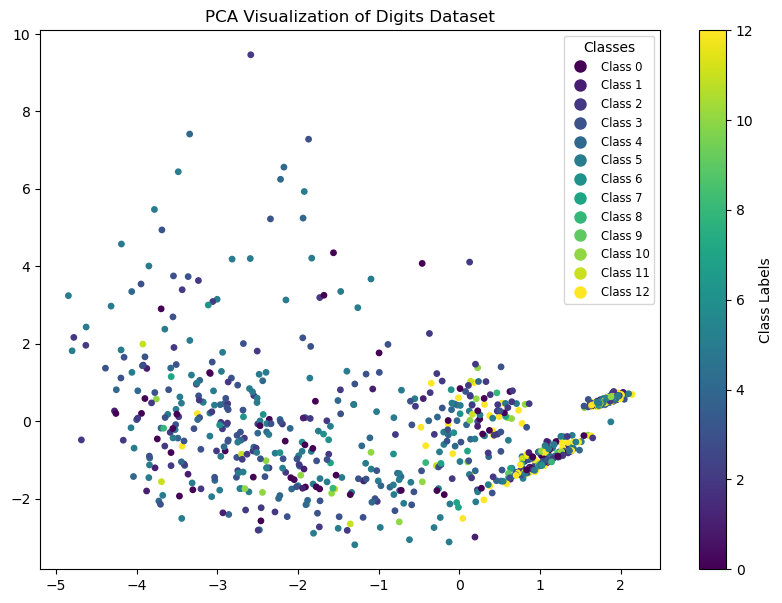

In [16]:
pca_vizualization(embeddings_node2vec, small_components_families_train + largest_component_families_train)

Добавление характеристик руками

In [17]:
from funcs.parsing import generate_random_kmers
random_kmers = generate_random_kmers(4, 100)

In [18]:
embeddings_char = []

for component_nodes in small_components_train:
    G_sub = G_small.subgraph(component_nodes)
    embedding_char = characteristics(G_sub, node_freq_dict_all['arab'], random_kmers, node2name_dict_all['arab'], name2seq_all['arab'])
    embeddings_char.append(embedding_char)
    
for component_nodes in largest_component_train:
    G_sub = G_largest.subgraph(component_nodes)
    embedding_char = characteristics(G_sub, node_freq_dict_all['arab'], random_kmers, node2name_dict_all['arab'], name2seq_all['arab'])
    embeddings_char.append(embedding_char)
print(len(embeddings_char), len(list(small_components_train)) + len(list(largest_component_train)))

1022 1022


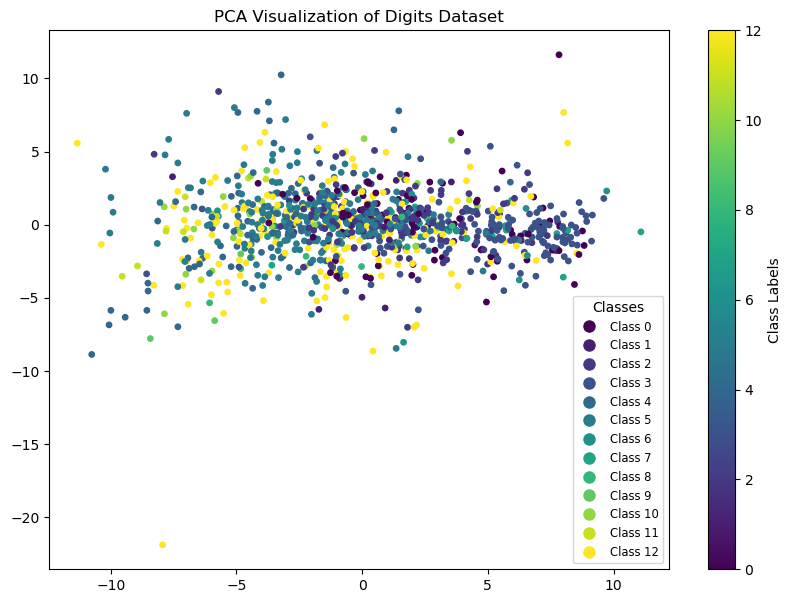

In [19]:
pca_vizualization(embeddings_char, small_components_families_train + largest_component_families_train)

## Комбинированные

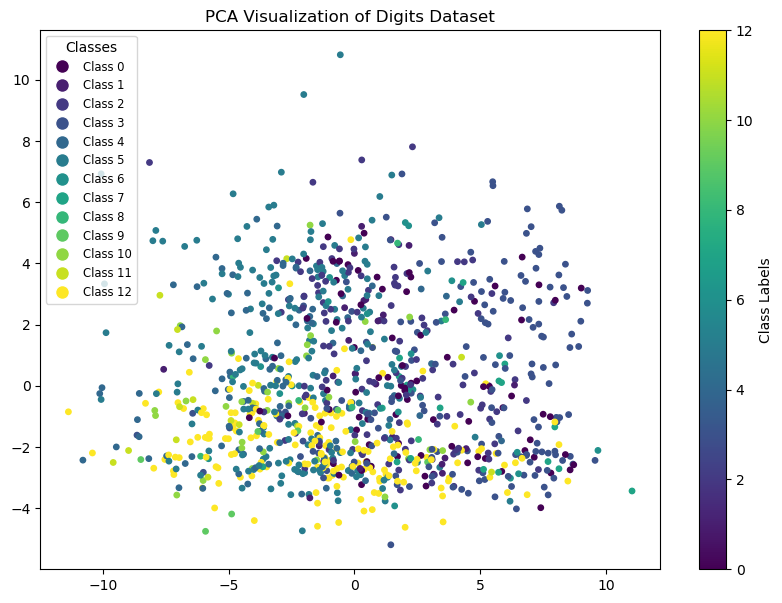

In [20]:
node2vec_char = [np.concatenate((a, b)) for a, b in zip(embeddings_node2vec, embeddings_char)]
pca_vizualization(node2vec_char, small_components_families_train + largest_component_families_train)

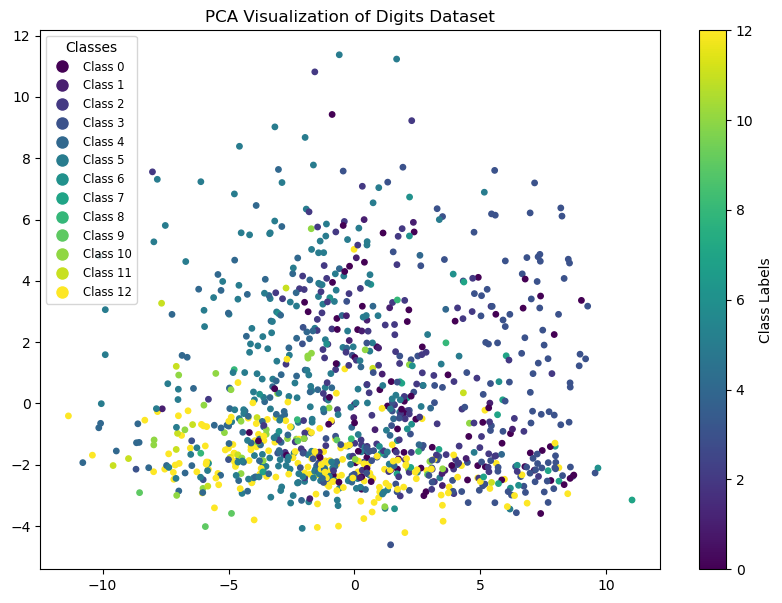

In [21]:
arope_char = [np.concatenate((a, b)) for a, b in zip(embeddings_arope, embeddings_char)]
pca_vizualization(arope_char, small_components_families_train + largest_component_families_train)

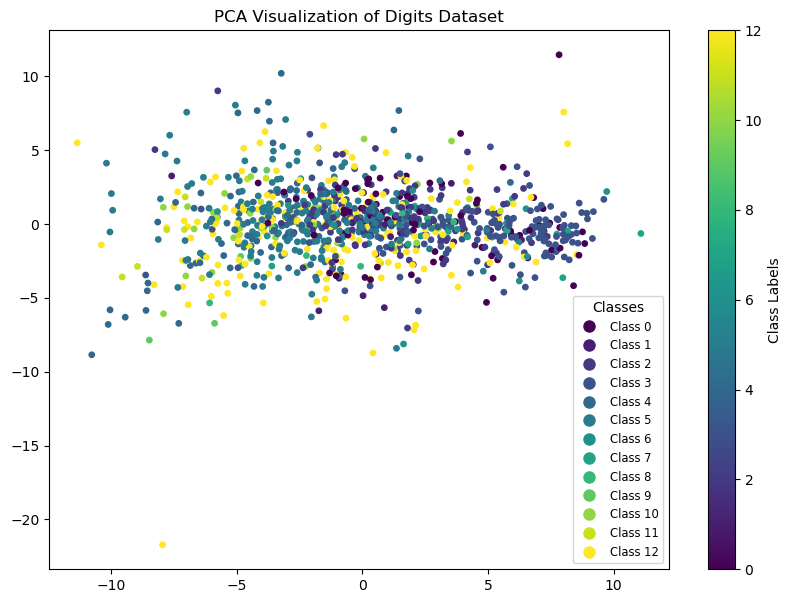

In [22]:
laplacian_eigenmaps_char = [np.concatenate((a, b)) for a, b in zip(embeddings_laplacian_eigenmaps, embeddings_char)]
pca_vizualization(laplacian_eigenmaps_char, small_components_families_train + largest_component_families_train)

In [23]:
data_filename = os.path.join('data', f'X_y_characteristics.pkl')
if not os.path.exists(data_filename):
    with open(data_filename, 'wb') as f:
        pickle.dump({
            'X': embeddings_char,
            'y': small_components_families_train + largest_component_families_train,
        }, f)

In [24]:
for name in names[1:]:
    small_components_test = small_components_all[name]
    largest_component_test = largest_component_all[name]
    
    small_components_families_test = small_components_families_all[name]
    largest_component_families_test = largest_component_families_all[name]
    
    G_small = G_small_all[name]
    G_largest = G_largest_all[name]
    
    X = []

    for component_nodes in small_components_test:
        G_sub = G_small.subgraph(component_nodes)
        embedding_char = characteristics(G_sub, node_freq_dict_all[name], random_kmers, node2name_dict_all[name], name2seq_all[name])
        X.append(embedding_char)
        
    for component_nodes in largest_component_test:
        G_sub = G_largest.subgraph(component_nodes)
        embedding_char = characteristics(G_sub, node_freq_dict_all[name], random_kmers, node2name_dict_all[name], name2seq_all[name])
        X.append(embedding_char)
    

    data_filename = os.path.join('data', f'X_y_{name}.pkl')
    if not os.path.exists(data_filename):
        with open(data_filename, 'wb') as f:
            pickle.dump({
                'X': X,
                'y': small_components_families_test + largest_component_families_test,
            }, f)